### A starting notebook for the lid-driven cavity project

In this package we seek to solve the lid-driven cavity problem

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/midterm")

"/Users/jeff/Dropbox/MAE250H/julia/midterm/Project.toml"

The usual set of notebooks

In [2]:
using Revise
using Plots
using LinearAlgebra
using project1

### First try out pure 2-d diffusion

In [3]:
# viscosity. This can be interpreted as 1/Re, since we will set the velocity and length both to 1
ν = 1

1

In [4]:
LX = 1  # length of x side
x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(0.0, 0.0)

#### Set boundary conditions of the problem

In [5]:
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = 0.0
uT(x,t) = 1*sin(π*x)

vL(y,t) = 0.0
vR(y,t) = 0.0
vB(x,t) = 0.0
vT(x,t) = 0*sin(π*x)

vT (generic function with 1 method)

### Now numerical parameters

In [6]:
NX = 64
NY = 64

64

In [7]:
Δx = LX/NX

0.015625

In [8]:
Fo = 5 # Fourier number: this choice should be explored!
Δt = Fo*Δx^2/ν

0.001220703125

### Assemble the physical and numerical parameters into a single structure

The following structure provides a convenient package for all of the parameters and bc functions we need for diffusion or N-S problems:

In [11]:
?NSParameters

search: NSParameters



```
NSParameters(ν,Δx,x0,y0,Δt,uL,uR,uB,uT,vL,vR,vB,vT)
```

Set the Navier-Stokes problem parameters


In [12]:
params = NSParameters(ν,Δx,x0,y0,Δt,uL,uR,uB,uT,vL,vR,vB,vT)

NSParameters(1, 0.015625, 0.0, 0.0, 0.001220703125, 5.0, uL, uR, uB, uT, vL, vR, vB, vT)

### Set up the initial condition

In [14]:
u0 = EdgeData(NX,NY);
rhs = EdgeData(u0);

### Solve the 2-d diffusion problem, using the delta formulation

In [15]:
tf = 1.0
nsteps = ceil(Int,tf/Δt)

# Initial conditions
t = 0.0
u = deepcopy(u0)

# Set up some arrays to store data
uarray = [deepcopy(u)]
tarray = [t]

# March!
for j = 1:nsteps
    global t, δu = diffuse2d_dirichlet_cn_delta(t,u,rhs,params)
    
    apply_dirichlet_bc!(δu)

    # now add
    u .+= δu
    
    # enforce boundary conditions on result
    apply_bc!(u,t,params)
    
    push!(uarray,deepcopy(u))
    push!(tarray,t)
end

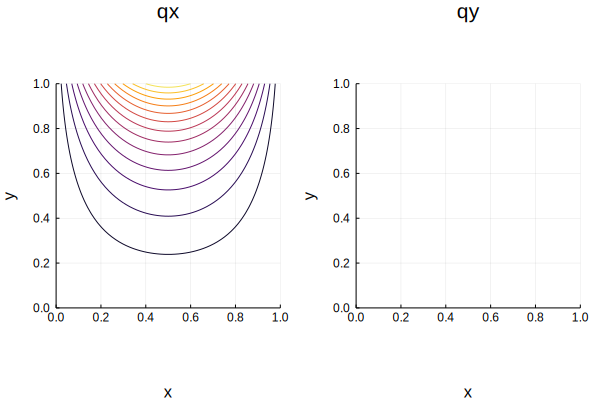

In [16]:
i_x,i_y = indices(u0,1,interior=false)
j_x,j_y = indices(u0,2,interior=false)

p1 = contour(xmap(i_x,u0.qx,params),ymap(j_x,u0.qx,params),transpose(uarray[end].qx[i_x,j_x]),legend=false,title="qx")
p2 = contour(xmap(i_y,u0.qy,params),ymap(j_y,u0.qy,params),transpose(uarray[end].qy[i_y,j_y]),legend=false,title="qy")
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(xmap(1,u0.qx,params),xmap(NX+1,u0.qx,params)),ylim=(ymap(1,u0.qy,params),ymap(NY+1,u0.qy,params)))

### Now solve Navier-Stokes in cavity

In [19]:
Re = 100
ν = 1/Re

0.01

In [20]:
NX = 128
NY = 128

128

In [21]:
Δx = LX/NX

0.0078125

In [22]:
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = 0.0
uT(x,t) = 1.0

vL(y,t) = 0.0
vR(y,t) = 0.0
vB(x,t) = 0.0
vT(x,t) = 0.0

vT (generic function with 1 method)

In [23]:
Fo = 5 # Fourier number
Co = 0.8 # Courant number
Δt = min(Fo*Δx^2/ν,Co*Δx)

# update the Fourier number
Fo = ν*Δt/Δx^2

1.024

In [24]:
params = NSParameters(ν,Δx,x0,y0,Δt,uL,uR,uB,uT,vL,vR,vB,vT)

NSParameters(0.01, 0.0078125, 0.0, 0.0, 0.00625, 1.024, uL, uR, uB, uT, vL, vR, vB, vT)

Set the multigrid parameters (not used if we use DCT instead)

In [25]:
#maxlev = floor(Int,log2(NX))+1
#mgparams = MGParameters(apply_neumann_bc!,1,1,1,1,maxlev,1e-8,10000,1000,1e-10)

#### Set the initial conditions and boundary conditions

In [26]:
t = 0.0
q0 = EdgeData(NX,NY);
global p = CellData(q0)
δp = CellData(q0)
apply_bc!(q0,t,params);
global q = deepcopy(q0)
qn = deepcopy(q0)

# temporary arrays
rhs = EdgeData(q)
nl = EdgeData(q)
f̃ = CellData(q)

iter = 0;

#### First time step is just forward Euler for convection

In [27]:
@time begin
    nl .= -convection(q)/Δx
    rhs .= Fo*laplacian(q) + Δt*nl
    q .+= rhs
    f̃ .= Δx/Δt*divergence(q)
    p .= f̃
    poisson_neumann_fft!(p)
    apply_neumann_bc!(p)

    #resid_norm = mg!(p,f̃,mgparams)

    q .-= Δt/Δx*gradient(p)
    apply_bc!(q,t,params);

    t += Δt
    iter +=1
    
    err = norm(q-qn)/Δt/norm(q)
    qn .= q
end
nothing

  4.586874 seconds (13.01 M allocations: 635.523 MiB, 6.84% gc time)


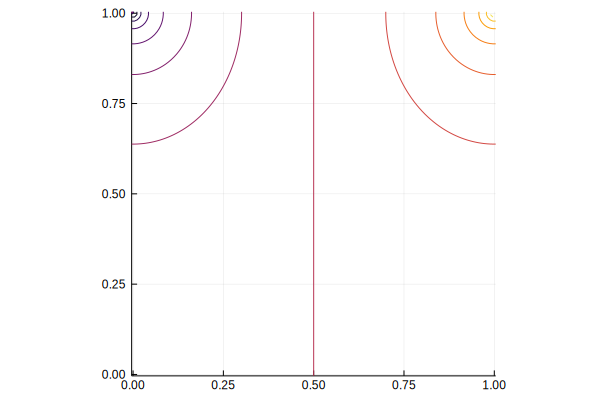

In [28]:
ic = indices(p,1,interior=false)
jc = indices(p,2,interior=false)
contour(xmap(ic,p,params),ymap(jc,p,params),transpose(p[ic,jc]),legend=false,ratio=1)

#### Now every subsequent step is 2nd-order Adams-Bashforth, and we apply algorithm in delta formulation

We run this to steady state, checking that results from one step to the next stop changing below some tolerance:

$$\dfrac{||dq/dt||_2}{||q||_2} < \mathrm{tol}$$

In [29]:
tol = 1e-2

# March until the error falls below tolerance
val, cput, bytes, gctime, memallocs = @timed while err > tol

    rhs .= -Δt/Δx*gradient(p) - 0.5*Δt*nl
    nl .= -convection(q)/Δx
    rhs .+= 1.5*Δt*nl
    
    # solve for δq*
    global t,δq = diffuse2d_dirichlet_cn_delta(t,q,rhs,params)
    
    apply_dirichlet_bc!(δq)

    # now solve for δp*
    f̃ .= Δx/Δt*divergence(δq)
    δp .= f̃
    poisson_neumann_fft!(δp)
    apply_neumann_bc!(δp)

    #resid_norm = mg!(δp,f̃,mgparams)
    
    # now project
    δq .-= Δt/Δx*gradient(δp)
    
    # now add the delta corrections
    global q .+= δq
    global p .+= δp
    
    # enforce boundary conditions on result
    apply_bc!(q,t,params)
    
    # update the error (difference from previous result)
    global err = norm(δq)/Δt/norm(q)
    
    global iter += 1
    
end

# Print some information about the simulation
println("Number of grid cells = ",NX*NY)
println("Final time at convergence = ",t)
println("Number of time steps = ",iter)
println("Total cpu time (s) = ",cput)
println("Total cpu time/step (s) = ",cput/iter)
println("Total cpu time/step/cell (s) = ",cput/iter/(NX*NY))

Number of grid cells = 16384
Final time at convergence = 6.568749999999894
Number of time steps = 1051
Total cpu time (s) = 16.493728785
Total cpu time/step (s) = 0.015693367064700283
Total cpu time/step/cell (s) = 9.578471108825856e-7


#### Plot the velocity component contours

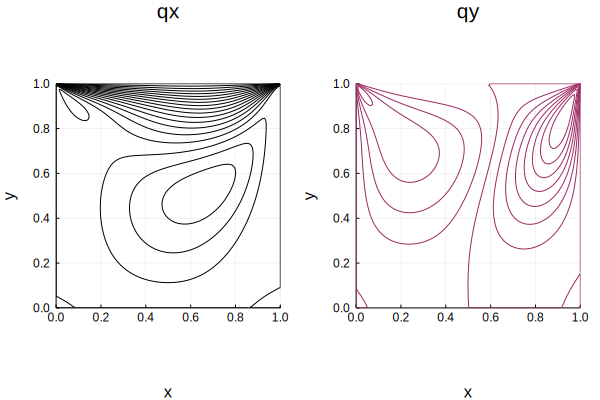

In [30]:
i_x,i_y = indices(q,1,interior=false)
j_x,j_y = indices(q,2,interior=false)

p1 = contour(xmap(i_x,q.qx,params),ymap(j_x,q.qx,params),transpose(q.qx[i_x,j_x]),levels=range(-1,1,length=31),legend=false,title="qx")
p2 = contour(xmap(i_y,q.qy,params),ymap(j_y,q.qy,params),transpose(q.qy[i_y,j_y]),levels=range(-1,1,length=31),legend=false,title="qy")
plot(p1,p2,layout=(1,2),xlabel="x",ylabel="y",ratio=1,xlim=(xmap(1,q.qx,params),xmap(NX+1,q.qx,params)),ylim=(ymap(1,q.qy,params),ymap(NY+1,q.qy,params)))

#### Compute the vorticity and streamfunction

In [31]:
w = curl(q)/Δx
ψ = NodeData(q)
maxlev = floor(Int,log2(NX))
mgparams2 = MGParameters(apply_dirichlet_bc!,1,1,1,1,maxlev,1e-6,10000,1000,1e-7)
resid_norm = mg!(ψ,-Δx^2*w,mgparams2)

0.00015435646613228113

#### Plot the streamlines

Set up the same contours as used by Ghia et al. (1982)

In [32]:
cnt = -[0.1175,0.115,0.11,0.1,9e-2,7e-2,5e-2,3e-2,1e-2,1e-4,1e-5,1e-7,1e-10,0,-1e-8,-1e-7,-1e-6,-1e-5,-5e-5,-1e-4,-2.5e-4,-5e-4,-1e-3,-1.5e-3,-3e-3];

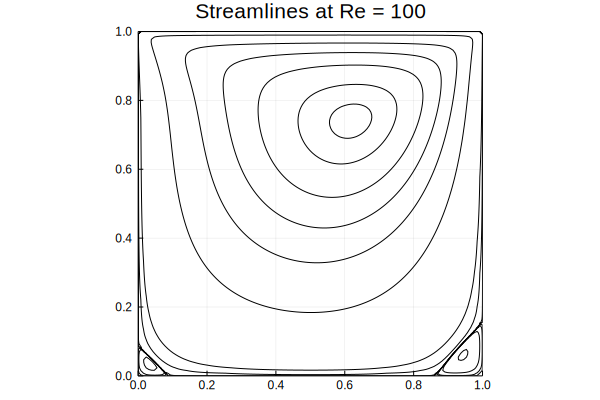

In [33]:
i_n = indices(w,1,interior=false)
j_n = indices(w,2,interior=false)
contour(xmap(i_n,ψ,params),ymap(j_n,ψ,params),transpose(ψ[i_n,j_n]),
    legend=false,ratio=1,levels=cnt,color=:black,title="Streamlines at Re = 100")

#### Plot the vorticity

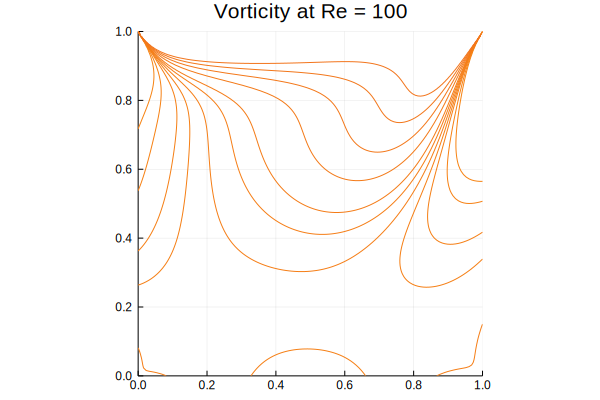

In [34]:
i_n = indices(w,1,interior=false)
j_n = indices(w,2,interior=false)
cnt = -[-3,-2,-1,-0.5,0,0.5,1,2,3,4,5]
contour(xmap(i_n,ψ,params),ymap(j_n,ψ,params),transpose(w[i_n,j_n]),levels=cnt,
    legend=false,ratio=1,title="Vorticity at Re = 100")

#### Plot a velocity profile and compare with results in Ghia et al (1982)

In [35]:
ughia100 = [1,0.84123,0.78871,0.73722,0.68717,0.23151,0.00332,-0.13641,-0.20581,-0.21090,-0.15662,-0.10150,-0.06434,-0.04775,-0.04192,-0.03717,0]
yghia = [1,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5000,0.4531,0.2813,0.1719,0.1016,0.0703,0.0625,0.0547,0];

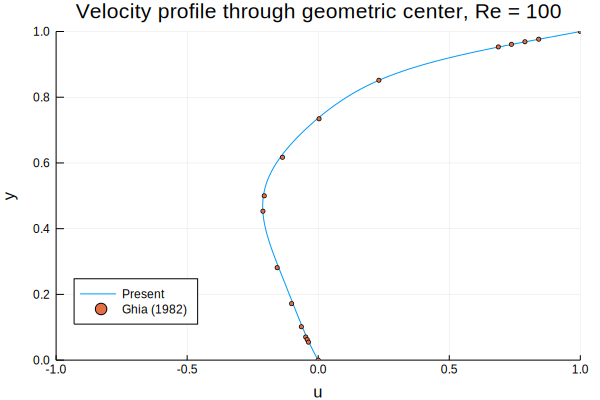

In [36]:
plot(0.5*(q.qx[65,j_x]+q.qx[66,j_x]),ymap(j_x,q.qx,params),ylim=(0,1),xlim=(-1,1),label="Present",title="Velocity profile through geometric center, Re = 100",xlabel="u",ylabel="y")
scatter!(ughia100,yghia,label="Ghia (1982)",markersize=2,legend=:bottomleft)